<h1><center> They say it's risky, should I go?</center></h1>
![avalanche](../images/avalanche2.gif)

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import folium
import branca
import json
import math 

##### Data loading:
We load fatal avalanche accidents datasets of the past 15 years.

In [2]:
df_accidents = pd.read_excel('../data/accidents/df_accidents_final.xlsx')

In the news, who has not seen articles relating deadly avalanche accidents ?

![avalanche](../images/accident_31_01_2015.jpg)

This photo was taken after an avalanche accident that killed 5 skiers at the Piz Vilan mountain. Here is the avalanche accident information taken from our dataset:

In [3]:
df_accidents.loc[236]

date             2015-01-31 00:00:00
Canton                            GR
Starting zone    Seewis im Prättigau
Elevation                       2340
Aspect                             E
Activity         Backcountry touring
Danger level                       3
caught                             8
buried                             7
killed                             5
Latitude                     47.0128
Longitude                    9.60505
temperature                   -11.04
wind                           fort 
Name: 236, dtype: object

- How many accidents are recensed each year ?
- Are there aspects associated with higher risks ?
- Do correlations exist between accidents and the danger levels, the altitude... ?

These questions are among the few we will try to answer by investigating avalanche accidents data.

But first, it is important to get a representation of the impact of avalanches, and their situation in Switzerland.
Let's visualize it on a map !

In [4]:
#swiss map
# Create map centered on Switzerland
switzerland = (46.875893, 8.289321)
m = folium.Map(location=switzerland, zoom_start=8, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')

import branca.colormap as cm

colors = ['#CCFF66','#FFFF00','#FF9B00', '#FF0000', '#800080']

colorscale = cm.StepColormap(
    colors,
    vmin=0., vmax=5.,
    index=range(6),
    caption="Avalanche Danger Level"
)

for i, values in df_accidents.iterrows():
    information = [
        ("Date", values["date"].strftime("%Y-%m-%d")),
        ("Starting zone", values["Starting zone"]),
        ("Elevation", values["Elevation"]),
        ("Danger level", int(values["Danger level"]) if not np.isnan(values["Danger level"]) else "None"),
        ("Caught", values["caught"]),
        ("Killed", values["killed"]),
    ]
    
    pop_up = folium.Popup("<dl>" + ''.join(["<dt>{}: </dt><dd>{}</dd>".format(k, v) for k, v in information]) + "</dl>")
    color_circle = colorscale(values['Danger level']) if values['Danger level'] >= 1 else '#808080'
    location = [values.Latitude, values.Longitude]
    folium.CircleMarker(location, popup=pop_up, color=color_circle, radius=5).add_to(m)
    
m.add_child(colorscale)
m

### Accidents evolution over time:

Knowing that an increasing number of people is skiing each year and do backcountry activity or off-piste skiing, we could suppose that the number of avalanche accidents is increasing each year. But is this true ?

In [5]:
df_accidents['year'] = df_accidents.date.apply(lambda d: d.year)

data = []
for canton in df_accidents['Canton'].unique():
    trace = Bar(
                x = df_accidents['year'].unique(),
                y = df_accidents[df_accidents['Canton']== canton].groupby(by='year')['date'].count(),
                name = canton
                )
    data.append(trace)

layout = Layout(title="Number of avalanches accidents per year",
                xaxis=dict(title='Year'),
                yaxis=dict(title='Count'), 
                barmode = 'stack')
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='avalanche_time_evolution')

Except a peak in 2014, there does not seem to be a significant increase in avalanche accidents along time. Even if backcountry touring and offpiste skiing have become more popular, resulting in an increase in people being at risk to be caught in avalanches, there has been an effort to prevent accidents by the authorities and make people aware of dangers they are facing, which allows to reduce risks.

### Inspecting the aspect

The aspect a slope is facing plays an important role in the creation of avalanche conditions.
In mid-winter, steep north-facing slopes are not exposed to any direct solar radiation. A south-facing slope falls to the south and also receives regular sunshine, even in mid-winter. It is common in springtime to see naturally triggered loose snow avalanches in the middle of the day. 
<br>
Thus, due to sun exposition at the end of the ski season, south-facing slope could possibly be more favourable to avalanches than in the beginning or middle of winter.

That is why the evolution of aspects between the beginning, the middle and the end of season are investigated.

In [6]:
order = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
start_date = [9, 0, 3]
end_date = [12, 3, 6]
vec_season = ['start','middle','end']
ratio = ['start_ratio','middle_ratio','end_ratio']
name = ['start of season','middle of season','end of season']

def get_ratio (start_date, end_date):
        
    mask = [(date.month > start_date) & (date.month <= end_date) for date in df_accidents['date']]
    total = df_accidents[mask]['Aspect'].value_counts().sum()
    aspect_ratio = (df_accidents[mask]['Aspect'].value_counts() / total)*100
    aspect_ratio = aspect_ratio.reset_index()
    aspect_ratio.columns = ['Aspect','Ratio']
    
    return aspect_ratio

In [133]:
for season_time in range(0,3):
    aspect_ratio = get_ratio(start_date[season_time],end_date[season_time])
    exec("aspect_ratio%d = aspect_ratio" % (season_time))

aspect_ratio_final = aspect_ratio.merge(aspect_ratio0.merge(aspect_ratio1, on = 'Aspect', how = 'outer'), on = 'Aspect', how = 'outer')
aspect_ratio_final.columns = ['Aspect','end_ratio','start_ratio','middle_ratio']
aspect_ratio_final = aspect_ratio_final.set_index('Aspect').reindex(order) 

data = []
for r in range(3):
    trace = Bar(
                x = aspect_ratio_final.loc['S'],#.index.values,
                y = aspect_ratio_final.loc['S',ratio[r]],#[ratio[r]],
                name = name[r])
    data.append(trace)

layout = Layout(title="Frequency of avalanche accidents for south aspect",
                xaxis=dict(title='Aspect'),
                yaxis=dict(title='Frequency'),
                )
fig = Figure(data=data, layout = layout)
py.iplot(fig, filename='avlanche_aspect_evolution')

We can see that considering south aspect accidents, most of them are at the end of the season.

###  Off-piste skiing or Backcountry touring ?

For which activity do we see most of the accidents ?

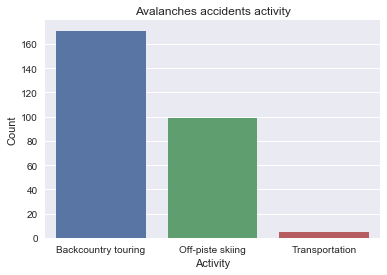

In [8]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Activity", data=df_accidents, ax=ax);
ax.set_title('Avalanches accidents activity');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

More accidents are related to backcountry touring activity.

But in which conditions do the skiiers go on a ride, depending on their activity ?
<br>
Is there a class of persons that is more educated on avalanche risks ?

In order to limit avalanche risk, it is important to be aware of the destructive power of avalanches, understand when and why they happen (snow and meteorological conditions). 
One of the main factor allowing to avoid accidents is increasing the awareness of the risks. And this begins with consulting the avalanche danger level before going on a ride.

Thus, it could be interesting to study skiiers' behaviour, and see if, depending on the activity (backcountry or off-piste), one group has a tendancy to be more risky considering avalanche danger levels. 
To answer this question, we decided to count the number of accidents per danger level, considering two groups: people doing backcountry touring and people doing off-piste skiing.

##### Propensity score matching:

Our hypothesis states that the behaviour of skiiers may depend on the activity they are doing.

But do draw valid conclusions, a propensity score matching is done. Propensity score purpose is to balance the dataset across treatment groups.
<br>
Propensity scores are used to match each data point from the treated group with exactly one data point from the control group. The matching allows to maximize the similarity between matched subjects, by balancing feature-value distributions between the two groups. 
<br>
In our case, the features taken into account for the matching are the aspect, the elevation and the temperature.

In [97]:
from sklearn import linear_model 
# Groups: activity --> backcountry and hors piste

# Create dic of aspect to get numerical values from aspect categories
aspect_cos = {}
aspect_sin = {}
for val, aspect in enumerate(order):
    aspect_cos[aspect]=math.cos(val*(math.pi/8))
    aspect_sin[aspect]=math.sin(val*(math.pi/8))

In [105]:
# Keep only 2 activities
df_accidents['survival_rate'] = (df_accidents.caught - df_accidents.killed)/df_accidents.caught
df = df_accidents[df_accidents.Activity != 'Transportation']
df = df[df.Activity != 'Building']
df = df[df['Danger level'].apply(lambda d: d in [2,3])]
df = df.set_index(['date','Longitude','Latitude'])

# Create feature matrix
df['cos_aspect'] = df.Aspect.replace(aspect_cos)
df['sin_aspect'] = df.Aspect.replace(aspect_sin)
features = df[['Activity','cos_aspect','sin_aspect','Elevation','caught','Danger level']]
features['Activity'] = features['Activity'].apply(lambda x: 1 if x == 'Backcountry touring' else 0)
features = features.dropna()

# Create data matrix
data = features
features = features.drop(['Danger level','Activity'], axis = 1)

_Use logistic regression to estimate propensity scores for all points in the dataset._

In [106]:
model = linear_model.LogisticRegression()
model.fit(features, data.Activity)
pred = model.predict(features)

accuracy = sum(pred == data.Activity) / len(data.Activity)
print('accuracy: ', accuracy)

accuracy:  0.601659751037


The propensity scores are calculated and added to the dataframe

In [107]:
# Get propensity score
pscore = model.predict_proba(features)
data = data.assign(propensity_score = pscore[:,0])
data.head(3)

,,,Activity,cos_aspect,sin_aspect,Elevation,caught,Danger level,propensity_score
date,Longitude,Latitude,,,,,,,
2002-01-02,7.528077,46.546476,1,9.238795e-01,-0.382683,2360,1,3.0,0.456897
2002-01-03,9.815028,46.855337,0,-1.836970e-16,-1.000000,2400,1,3.0,0.363403
2002-01-13,9.830075,46.836754,0,6.123234e-17,1.000000,2240,1,2.0,0.412987


The propensity scores are used to match each data point from the backcountry skiing group with exactly one data point from the off-piste skiing group. To do that, we decided to use networkx package and work with DiGraph, which corresponds to directed graph with self loops.

In [123]:
import networkx as nx

G = nx.DiGraph()

# add a node for each sample
for i, row in data.iterrows():
    G.add_node(row.name, propensity=row['propensity_score'], Activity=row['Activity'])

# add an edge between treated control with propensity diff as weight
for n1, att1 in G.nodes(data=True):
    for n2, att2 in G.nodes(data=True):
        if att1['Activity'] == 1 and att2['Activity'] == 0:
            diff = abs(att1['propensity'] - att2['propensity'])
            G.add_edge(n1, n2, weight=1-diff)

matchings = nx.max_weight_matching(G)

Doublons are found for the matching.
So we split the matching output to get only unique matches (85 in total, as it should).

In [124]:
matchings
true_matching = {}

for treat,no_treat in matchings.items():
    if treat not in true_matching.values():
        true_matching[treat] = no_treat

The new matching is aplied to our dataset.

In [125]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_offpiste = data.loc[[off_piste for backcountry, off_piste in true_matching.items()]]

# Assign propensity score matching to the dataframe to keep only matched datapoints
data_backcountry = data.loc[[backcountry for backcountry, off_piste in true_matching.items()]]

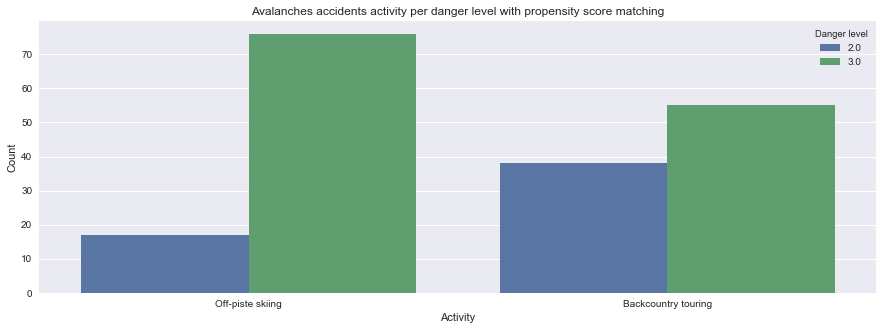

In [126]:
data_new = pd.concat([data_offpiste,data_backcountry])
fig, ax = plt.subplots(1, sharey=True, figsize=(15,5));

g = sns.countplot(x="Activity", hue = 'Danger level', data=data_new, ax = ax);
g.set(xticklabels=['Off-piste skiing','Backcountry touring'])
ax.set_title('Avalanches accidents activity per danger level with propensity score matching');
ax.set_xlabel('Activity');
ax.set_ylabel('Count');

From our results, accidents due to people doing backcountry are associated with lower danger levels than accidents caused by people who did off-piste skiing. This could suggest a difference of behaviour between both groups. Indeed, this result could be explained by the fact that people doing backcountry touring have a better knowledge and awareness of the risks than people doing off-piste skiing.

It could also be interesting to confirm our hypothesis by applying a statistical test.
Thus, we investigate the mean difference of avalanche danger levels between the two groups, which are off-piste skiing group and backcountry touring group.
To do that, we decided to perform an independant 2 sample t-test to test if, wether or not, the difference in danger level is significant between the groups. So our hypothesis are:
- Ho: There is no difference between the two means
- Ha: There is a difference between the two means

In [127]:
# Student t-test
from scipy import stats
t, p = stats.ttest_ind(data_offpiste['Danger level'], data_backcountry['Danger level'])

if p<0.05:
    print( 'p = %f --> The independant 2 sample student t-test rejects the null Hypothesis' %p)

p = 0.015828 --> The independant 2 sample student t-test does reject the null Hypothesis


The student t-test gives a p-value lower than 0.05, and confirms our first assumption.
A propensity score matching was asessed to balance the dataset in order to draw proper conclusions.
Thus, a preventive behaviour may allow to reduce the avalanche risk.